# Constraining FATES parameters for conifer and oak allometry

This notebook uses observational data from the BAAD database to constrain fates parameters for a oak and conifer allometry

## Setup <a class="anchor" id="setup"></a>
* Import libraries
* Set paths to data
* Define constants

In [8]:
#import libraries
import pandas as pd
import numpy as np
from numpy import genfromtxt
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
import os
#jupyter settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)
import re

In [9]:
path_to_trait_obs = "/home/adamhb/gdrive/postdoc/parameters/param_data/trait_observations"
baad_data = os.path.join(path_to_trait_obs,"conifer_allometry/baad_data/baad_data.csv")
urban_tree_db = os.path.join(path_to_trait_obs,'conifer_allometry/McPherson_urban_tree_database/TS3_Raw_tree_data.csv')
tallo_db = os.path.join(path_to_trait_obs,"conifer_allometry/Tallo.csv")

pollys_allom_params = os.path.join("/home/adamhb/gdrive/postdoc/parameters/pollys_allom_params.csv")

write_to_csv = False
pft_names = ['Pine','Cedar','Fir','Oak']
sp_names = ['Pinus ponderosa','Calocedrus decurrens','Abies grandis']
pft_colors = ['gold','black','darkolivegreen','springgreen']
pft_symbols = ['s','o','^','v']

## Constants

In [10]:
#define constants
m2_per_cm2 = 1e-4
g_biomass_per_g_C = 2
m2_per_mm2 = 1e-6
mg_per_g = 1e3
g_per_kg = 1000
mm2_per_cm2 = 100
c2b = g_biomass_per_g_C

### Define target trees

In [11]:
target_trees = ['Pinus ponderosa','Calocedrus decurrens','Abies concolor','Quercus chrysolepis'
                'Quercus kelloggii','Quercus douglasii','Quercus agrifolia','Quercus wislizeni','Abies grandis']

### Define allom df

In [12]:
allom_vars = ['species','dbh_cm','height_m','leaf_biomass_kgC',
              'agwb_kgC','agb_kgC','crown_area_m2','source']

## Functions

In [13]:

#https://doi.org/10.1016/S0378-1127(99)00113-9
def Gill_2000(ds,b0,b1):
    
    r = []
    ca = []
    
    for d in ds:
        radius_tmp = b0 + b1 * d
        r.append(radius_tmp)
        ca_tmp = math.pi * radius_tmp **2
        ca.append(ca_tmp)
    return r,ca

def get_allom_param_value(sp,allom_mod,fates_name):
    
    allom_params_df = pd.DataFrame(allometry_dict)
    
    filt = (allom_params_df['sp'] == sp) & (allom_params_df['allom_mod'] == allom_mod) & (allom_params_df['fates_name'] == fates_name)
    return np.array(allom_params_df.loc[filt][['min_value','max_value','mean']])[0,:]

#diamter to height
def d2h_obrien(ds,p1,p2,dbh_maxh):
    '''Input; dbh (cm)
    Returns: height (m)'''
    
    h = []
    for d in ds:
        h.append(10.0**(math.log10(min(d,dbh_maxh))*p1+p2))
    return(h)


def d2h_poorter2006(ds,p1,p2,p3,dbh_maxh):
    
    h = []
    
    for d in ds:
        h.append(p1 * (1.0 - np.exp(p2 * min(d,dbh_maxh)**p3)))
        
    return h

# diameter to max leaf biomass
# why no carbon to leaf biomass multiplier here (not in the main fates code?)
# https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L1403
def d2blmax_salda(ds,p1,p2,p3,wood_density,dbh_maxh):
    '''Input; dbh (cm)
    Returns: plant leaf biomass (kg)'''
    
    blmax = []
    
    for d in ds:
        if d < dbh_maxh:
            blmax.append(p1 * d**p2 * wood_density**p3)
        else:
            blmax.append(p1 * dbh_maxh**p2 * wood_density**p3)
    
    return(blmax)

#diameter and height to above-ground biomass (just structural and sapwood biomass)
def dh2bagw_salda(p1, p2, p3, p4, allom_agb_frac,ds,heights,wood_density):
    
    '''Input; dbh (cm)
    Returns: woody above-ground biomass (kg)'''
    
    bagw = []
    
    for d,h in zip(ds,heights):
    
        bagw.append(allom_agb_frac*p1*(h**p2)*(d**p3)*(wood_density**p4))
    
    return(bagw)

#2-param power function for diameter (cm) to plant above-ground biomass (kgC)
def d2bagw_2pwr(d,p1,p2,c2b):
    bagw = []
    for i in d:
        bagw.append((p1 * i**p2)/c2b)
    return bagw

#This is a power function for leaf biomass from plant diameter
def d2blmax_2pwr(d,p1,p2,c2b,dbh_maxh):
    '''input dbh [cm]
    output: plant leaf biomass [kg C]'''
    blmax = []
    for i in d:
        blmax.append((p1*min(i,dbh_maxh)**p2) / c2b)   
    return blmax

def carea_2pwr(ds, p1, p2):
    c = []
    for d in ds:
        c.append(p1 * d ** p2)
    return c

def d_to_crown_area_fates(ds,d2bl_p2,d2bl_ediff,spread,d2ca_max,d2ca_min, dbh_maxh):
    
    '''Input dbh (cm)
    Output: crown area (m2)'''
    
    ca = []
    cd = []
    
    for d in ds:
        #from fates
        
        if d > dbh_maxh:
            d = dbh_maxh
        
        crown_area_to_dbh_exponent = d2bl_p2 + d2bl_ediff
        spreadterm = spread * d2ca_max + (1.0 - spread) * d2ca_min
        tmp_ca = spreadterm * d ** crown_area_to_dbh_exponent
        ca.append(tmp_ca)

        #convert to crown diameter
        cd.append(2 * math.sqrt(tmp_ca/math.pi))

    return ca,cd

def age_senescence(age, mort_r_age_senescence, mort_ip_age_senescence):
    out = []
    for i in age:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_age_senescence * (i - mort_ip_age_senescence))))
    return out


def size_senescence(size, mort_r_size_senescence, mort_ip_size_senescence):
    out = []
    for i in size:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_size_senescence * (i - mort_ip_size_senescence))))
    return out

def prep_data_for_curve_fit(df,sp,dbh_var,var):
    df = df.loc[df['species'].isin(sp)]
    
    if type(var) == list:
        var.append(dbh_var) 
        df = df[var].dropna()
    else:
        df = df[[dbh_var,var]].dropna()
    return df


    
def add_param_to_allometry_dict(fates_name,min_max_mean,sp,allom_mod):
    
    allometry_dict["fates_name"].append(fates_name)
    allometry_dict["min_value"].append(min_max_mean[0])
    allometry_dict["max_value"].append(min_max_mean[1])
    allometry_dict["mean"].append(min_max_mean[2])
    allometry_dict["sp"].append(sp)
    allometry_dict["allom_mod"].append(allom_mod)
    
    
# This function gets the optimal parameter value from the curve fit function and
# also returns the min and max values for the parameter (+- 1 SD of error)
def getMeanMinMaxofParam(param):
    sd_of_param = np.sqrt(np.diag(pcov))[param]
    mean_value = popt[param]
    min_value = popt[param] - sd_of_param
    max_value = popt[param] + sd_of_param
    return(np.array([min_value, max_value, mean_value]))

def convert_to_fates_units(trait_name,input_units,input_value):

    
    if ("SLA" in trait_name) | ("Specific leaf area" in trait_name) and input_units == "mm2 mg-1":  
        output_value = input_value * m2_per_mm2 * mg_per_g * g_biomass_per_g_C
        return output_value

    elif "Leaf nitrogen" in trait_name and input_units == "mg/g":
        output_value = input_value * g_per_mg * g_biomass_per_g_C
        return output_value

    elif "Stem specific density" in trait_name and input_units == "g/cm3":
        output_value = input_value
        return output_value
    
    # Anaker conversions
    elif trait_name == "log(SLA cm2 g-1)":
        output_value = np.exp(input_value) * m2_per_cm2 * g_biomass_per_g_C
        return output_value
        
    elif trait_name == 'log(wood density g ml-1)':
        output_value = np.exp(input_value)
        return output_value
        
    elif trait_name == 'log(N %)':
        output_value = np.exp(input_value) * 1e-2 * g_biomass_per_g_C
        return output_value
    
    #Jepson leaf N
    elif trait_name == "Leaf Nmass":
    
        # muliplying by 1e-2 is to reverse the "per cent"  
        output_value = input_value * 1e-2 * g_biomass_per_g_C
        return output_value
    
    elif "Wood density" in trait_name:
        output_value = input_value
        return output_value
    
    elif trait_name == "Leaf area to sapwood area" and input_units == "mm2 mm-2":
        output_value = input_value * 1e-4
        return output_value
    
    elif "Vcmax" in trait_name and input_units == "micro mol m-2 s-1":
        output_value = input_value
        return output_value
    
    else:
        #print("No unit conversion known for:", trait_name)
        return None
    
def convert_to_fates_param_name(input_trait_name):
    if ("SLA" in input_trait_name) | ('Specific leaf area' in input_trait_name):
        return "fates_leaf_slatop"
    
    elif ("wood density" in input_trait_name) |  ("Wood density" in input_trait_name):
        return "fates_wood_density"
    
    elif ("N %" in input_trait_name) | ("Leaf Nmass" in input_trait_name):
        return "fates_stoich_nitr"
    
    elif "Leaf nitrogen (N) content per leaf dry mass" in input_trait_name:
        return "fates_stoich_nitr"
    
    elif "Leaf area to sapwood area" in input_trait_name:
        return "fates_allom_la_per_sa_int"
    
    elif "Vcmax" in input_trait_name:
        return "fates_leaf_vcmax25top"
    
    else:
        return None
    
def get_sources(df,variable):
    return df.loc[df.fates_name == variable].source.unique()

def get_range_data(df,subset_name):

    summary_stats = df.groupby('fates_name')['fates_value'].agg(
        min_value='min',
        max_value='max',
        mean='mean',
        median='median',
        sample_size='size'
    )

    summary_stats['subset_name'] = subset_name
    
    return summary_stats

#def check_vai_max(dbh,sai_scaler,sla,d2bl1):
def Chojnacky_d2_AGB_single_value(d,b0,b1):
    '''input: diameters [cm],
    output: AGB [kg C]'''    
    log_agb = b0 + b1 * np.log(d)
    agb = np.exp(log_agb) / g_biomass_per_g_C
    return agb


def Chojnacky_d2_AGB(ds,b0,b1):
    '''input: diameters [cm],
    output: AGB [kg C]'''
    
    agb = []
    for i,d in enumerate(ds):
        
        log_agb = b0 + b1 * np.log(d)
        agbh_temp = np.exp(log_agb) / g_biomass_per_g_C
        agb.append(agbh_temp)
    return agb

## Explore and import data from Baad database

Baad only has data for ponderosa pine

In [14]:
# This just includes the species we're primarily trying to model.
# The target species are used for allometry
## Import crown area data for PIPO from Baad
baad_df = pd.read_csv(baad_data)

for sp in target_trees:
    print(len(baad_df[baad_df['species'] == sp]))
    
    
# This just includes the species we're primarily trying to model.
# The target species are used for allometry
## Import crown area data for PIPO from Baad
baad_df = pd.read_csv(baad_data)

print(baad_df.loc[baad_df['species'].str.contains("Abies")]['species'].value_counts())

print(np.unique(baad_df.loc[baad_df['species'].str.contains("Quercus")]['species']))

# for sp in target_trees:
#     print(len(baad_df[baad_df['species'] == sp]))

272
0
0
0
0
0
0
72
Abies lasiocarpa       405
Abies balsamea         204
Abies sachalinensis    129
Abies grandis           72
Abies firma             27
Abies veitchii          16
Name: species, dtype: int64
['Quercus acutissima' 'Quercus alba L.' 'Quercus coccinea Muenchh.'
 'Quercus crispula' 'Quercus ellipsoidalis' 'Quercus gilva'
 'Quercus glauca' 'Quercus myrsinaefolia' 'Quercus phillyreoides'
 'Quercus prinus L.' 'Quercus pyrenaica' 'Quercus rubra'
 'Quercus rubra L.' 'Quercus salicifolia' 'Quercus salicina'
 'Quercus serrata' 'Quercus sessilifolia' 'Quercus shumardii'
 'Quercus spp.' 'Quercus variabilis']


### Clean Baad data

In [15]:
## Import data for PIPO from Baad
baad_df = pd.read_csv(baad_data)
baad_df = baad_df.loc[baad_df['species'].isin(target_trees)]
baad_df = baad_df[['species','d.bh','m.lf','a.cp','h.t']]
baad_df['crown_area_m2'] = baad_df['a.cp']
baad_df['leaf_biomass_kgC'] = baad_df['m.lf'] / g_biomass_per_g_C
baad_df['dbh_cm'] = baad_df['d.bh'] * 100
baad_df['height_m'] = baad_df['h.t']
baad_df['agwb_kgC'] = None
baad_df['agb_kgC'] = None
baad_df['source'] = "Baad"
baad_df = baad_df[allom_vars]
#baad_df = baad_df[]
print(baad_df.info())
baad_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 3428 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           344 non-null    object 
 1   dbh_cm            322 non-null    float64
 2   height_m          340 non-null    float64
 3   leaf_biomass_kgC  222 non-null    float64
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     193 non-null    float64
 7   source            344 non-null    object 
dtypes: float64(4), object(4)
memory usage: 24.2+ KB
None


,species,dbh_cm,height_m,leaf_biomass_kgC,agwb_kgC,agb_kgC,crown_area_m2,source
3428,Pinus ponderosa,NaN,0.70104,0.042003,None,None,0.186793,Baad
3437,Abies grandis,NaN,0.94488,0.078495,None,None,0.321780,Baad
3446,Abies grandis,NaN,1.12776,0.087998,None,None,0.572052,Baad
3448,Abies grandis,NaN,1.12776,0.041005,None,None,0.164173,Baad
3450,Abies grandis,NaN,1.12776,0.102491,None,None,0.263407,Baad


## Explore and import data from McPerhson urban tree database

In [16]:
mcpherson_df = pd.read_csv(urban_tree_db)
mcpherson_df.loc[mcpherson_df['ScientificName'].isin(target_trees)]["ScientificName"].unique()

array(['Quercus agrifolia', 'Pinus ponderosa', 'Calocedrus decurrens'],
      dtype=object)

### Clean McPherson data

In [17]:
mcpherson_df = pd.read_csv(urban_tree_db)

# McPherson tree codes of interest
mcpher_codes = ['PIPO','PSME','QUAG','CADE2']

# McPherson vars of interest
mcpher_vars = ['SpCode','ScientificName','DBH (cm)','Age','TreeHt (m)','AvgCdia (m)','Leaf (m2)']

mcpherson_df = mcpherson_df.loc[mcpherson_df['SpCode'].isin(mcpher_codes)][mcpher_vars]
mcpherson_df.head()


#Clean
mcpherson_df['species'] = mcpherson_df['ScientificName']
mcpherson_df['dbh_cm'] = mcpherson_df['DBH (cm)']
mcpherson_df['height_m'] = mcpherson_df['TreeHt (m)']
mcpherson_df['leaf_biomass_kgC'] = mcpherson_df['Leaf (m2)'] * 251.98 / 1000 / g_biomass_per_g_C # QUAG foliar biomass factor taken from Table 6 of McPherson et al., 2016
#df.loc[(df['Column A'] > 15) & (df['Column B'] == 'Cat1'), 'Column A'] = 999
mcpherson_df.loc[mcpherson_df['SpCode'] != 'QUAG','leaf_biomass_kgC'] = None
mcpherson_df.loc[mcpherson_df['leaf_biomass_kgC'] < 0,'leaf_biomass_kgC'] = None
mcpherson_df['agwb_kgC'] = None
mcpherson_df['agb_kgC'] = None
mcpherson_df['crown_area_m2'] = math.pi * (mcpherson_df['AvgCdia (m)'] / 2)**2
mcpherson_df['source'] = "McPherson_2016"
mcpherson_df = mcpherson_df[allom_vars]
print(mcpherson_df.info())

# Could do this if helpful
#Add foliar biomass for QUAG to McPherson data
#mcpherson_df['leaf_biomass_g'] = mcpherson_df['Leaf (m2)'] * 251.98 # QUAG foliar biomass factor taken from Table 6 of McPherson et al., 2016

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 1343 to 13462
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           241 non-null    object 
 1   dbh_cm            241 non-null    float64
 2   height_m          241 non-null    float64
 3   leaf_biomass_kgC  70 non-null     float64
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     241 non-null    float64
 7   source            241 non-null    object 
dtypes: float64(4), object(4)
memory usage: 16.9+ KB
None


## Explore and import data from Tallo

In [18]:
tallo_df = pd.read_csv(tallo_db)
tallo_df = tallo_df.loc[tallo_df['species'].isin(target_trees)]
print(tallo_df.species.value_counts())
print(tallo_df.info())

Pinus ponderosa         623
Abies concolor          195
Abies grandis           137
Quercus douglasii        51
Quercus wislizeni        33
Calocedrus decurrens     14
Name: species, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053 entries, 80263 to 495591
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tree_id               1053 non-null   object 
 1   division              1053 non-null   object 
 2   family                1053 non-null   object 
 3   genus                 1053 non-null   object 
 4   species               1053 non-null   object 
 5   latitude              1053 non-null   float64
 6   longitude             1053 non-null   float64
 7   stem_diameter_cm      1053 non-null   float64
 8   height_m              1053 non-null   float64
 9   crown_radius_m        643 non-null    float64
 10  height_outlier        1053 non-null   object 
 11  crown_radius_outlier  1

### Clean tallo data

In [19]:
tallo_df = pd.read_csv(tallo_db)

tallo_df = tallo_df.loc[tallo_df['species'].isin(target_trees)]

#Clean
tallo_df['dbh_cm'] = tallo_df['stem_diameter_cm']
tallo_df['leaf_biomass_kgC'] = None
tallo_df['agwb_kgC'] = None
tallo_df['agb_kgC'] = None
tallo_df['crown_area_m2'] = math.pi * tallo_df['crown_radius_m']**2
tallo_df['source'] = "Tallo"
tallo_df = tallo_df[allom_vars]
print(tallo_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053 entries, 80263 to 495591
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1053 non-null   object 
 1   dbh_cm            1053 non-null   float64
 2   height_m          1053 non-null   float64
 3   leaf_biomass_kgC  0 non-null      object 
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     643 non-null    float64
 7   source            1053 non-null   object 
dtypes: float64(3), object(5)
memory usage: 74.0+ KB
None


In [20]:
tallo_df.head()

,species,dbh_cm,height_m,leaf_biomass_kgC,agwb_kgC,agb_kgC,crown_area_m2,source
80263,Abies grandis,1.0,1.7,None,None,None,0.785398,Tallo
80266,Pinus ponderosa,1.0,1.6,None,None,None,0.636173,Tallo
80267,Abies grandis,1.0,1.7,None,None,None,0.785398,Tallo
80455,Pinus ponderosa,1.3,2.0,None,None,None,NaN,Tallo
80585,Pinus ponderosa,1.5,2.6,None,None,None,NaN,Tallo


## Join conifer allometry data

In [21]:
tree_allom_df = pd.concat([tallo_df,mcpherson_df,baad_df])
tree_allom_df.info()

# General plan forward is to give cedar the same allometry as pine and have fir have its own (fixed)
# leaf biomass allometry and different d2ca range

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 80263 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1638 non-null   object 
 1   dbh_cm            1616 non-null   float64
 2   height_m          1634 non-null   float64
 3   leaf_biomass_kgC  292 non-null    object 
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     1077 non-null   float64
 7   source            1638 non-null   object 
dtypes: float64(3), object(5)
memory usage: 115.2+ KB


## Add total above-ground biomass from Chojnacky et al. 2015

We are doing this for the species where we have leaf biomass so that we can estimate woody above-ground biomass

In [22]:
np.unique(tree_allom_df.loc[pd.notnull(tree_allom_df['leaf_biomass_kgC'])]['species'])

array(['Abies grandis', 'Pinus ponderosa', 'Quercus agrifolia'],
      dtype=object)

In [23]:
PIPO_indices = tree_allom_df['species'] == "Pinus ponderosa"
ABGR_indices = tree_allom_df['species'] == "Abies grandis"
QUAG_indices = tree_allom_df['species'] == "Quercus agrifolia"


Chojnacky_params = {"taxa":['Abies-gt-0.35-spg','Pinus-lt-0.45-spg','Fagaceae-evergreen'],
                    "b0":[-3.1774,-2.6177,-2.2198],
                    "b1":[2.6426,2.4638,2.4410]}

ABGR_agb_kgC = tree_allom_df.loc[ABGR_indices, 'dbh_cm'].apply(lambda x: Chojnacky_d2_AGB_single_value(x,b0=Chojnacky_params['b0'][0],b1=Chojnacky_params['b1'][0]))
tree_allom_df.loc[ABGR_indices, 'agb_kgC'] = ABGR_agb_kgC

PIPO_agb_kgC = tree_allom_df.loc[PIPO_indices, 'dbh_cm'].apply(lambda x: Chojnacky_d2_AGB_single_value(x,b0=Chojnacky_params['b0'][1],b1=Chojnacky_params['b1'][1]))
tree_allom_df.loc[PIPO_indices, 'agb_kgC'] = PIPO_agb_kgC

QUAG_agb_kgC = tree_allom_df.loc[QUAG_indices, 'dbh_cm'].apply(lambda x: Chojnacky_d2_AGB_single_value(x,b0=Chojnacky_params['b0'][2],b1=Chojnacky_params['b1'][2]))
tree_allom_df.loc[QUAG_indices, 'agb_kgC'] = QUAG_agb_kgC

## Calculate above-ground woody biomass

In [24]:
# Pick up here with subtracting leaf biomass to get above-ground woody biomass
tree_allom_df['agwb_kgC'] = tree_allom_df['agb_kgC'] - tree_allom_df['leaf_biomass_kgC']
tree_allom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 80263 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1638 non-null   object 
 1   dbh_cm            1616 non-null   float64
 2   height_m          1634 non-null   float64
 3   leaf_biomass_kgC  292 non-null    object 
 4   agwb_kgC          278 non-null    object 
 5   agb_kgC           1246 non-null   object 
 6   crown_area_m2     1077 non-null   float64
 7   source            1638 non-null   object 
dtypes: float64(3), object(5)
memory usage: 115.2+ KB


## Import Polly's parameters

In [25]:
#Import polly's parameters
polly_allom = pd.read_csv(pollys_allom_params)

#Put them in a dictionary for easier access
pollys_params = [{},{},{}]
for pft in range(0,3):
    for index, row in polly_allom.iterrows():
        pollys_params[pft][row['param']] = row[pft+1]

## Set up dictionary to store allometry param values

In [26]:
allometry_dict = {}

for i in ['fates_name','min_value','max_value','mean','sp','allom_mod']:
    allometry_dict[i] = []
    
# diameters [cm] to plot allom functions against
diams = list(range(1,100))

## Diameter to height

We exclude the McPherson data for height allometry data for all trees except oak because it seems to have a low height bias compared to tallo and baad, perhap related to the trees being trimmed in urban areas (it is an urban tree dataset).

In [27]:
McPherson_QUAG_data = tree_allom_df.loc[tree_allom_df['species'] == "Quercus agrifolia"]

tree_allom_df_height = tree_allom_df.loc[tree_allom_df['source'] != "McPherson_2016"]

tree_allom_df_height = pd.concat([tree_allom_df_height,McPherson_QUAG_data])

tree_allom_df_height.info()

tree_allom_df_height['species'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 80263 to 3057
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1500 non-null   object 
 1   dbh_cm            1478 non-null   float64
 2   height_m          1496 non-null   float64
 3   leaf_biomass_kgC  292 non-null    object 
 4   agwb_kgC          278 non-null    object 
 5   agb_kgC           1185 non-null   object 
 6   crown_area_m2     939 non-null    float64
 7   source            1500 non-null   object 
dtypes: float64(3), object(5)
memory usage: 105.5+ KB


Pinus ponderosa         895
Abies grandis           209
Abies concolor          195
Quercus agrifolia       103
Quercus douglasii        51
Quercus wislizeni        33
Calocedrus decurrens     14
Name: species, dtype: int64

### Conifer height allometry is similar among species

Pine, cedar, and fir are assumed to have the same height allometry as eachother as in Buotte 2021.

Oak height allometry comes from QUAG (same as Charlie) base on data availability.

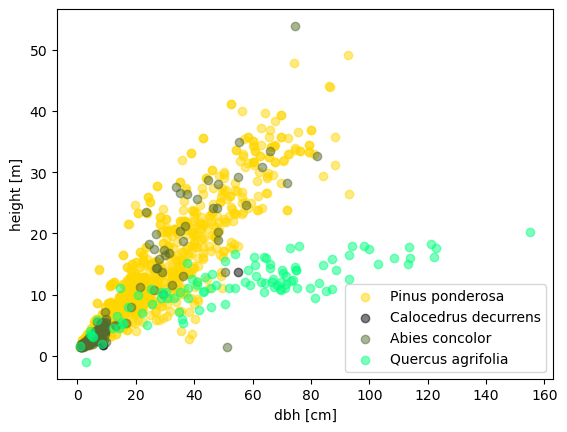

In [28]:
sp_names_height = ['Pinus ponderosa','Calocedrus decurrens','Abies concolor','Quercus agrifolia']

height_data = []

for i,p in enumerate(sp_names_height):
    height_data.append(prep_data_for_curve_fit(tree_allom_df_height,[p],"dbh_cm","height_m"))
    plt.scatter(height_data[i]['dbh_cm'],height_data[i]['height_m'],label=p,color = pft_colors[i],alpha=0.5)
    plt.legend()

plt.xlabel('dbh [cm]')
plt.ylabel('height [m]')
#plt.xlim(0,20)
plt.show()

### Find optimal params

We will use FATES's [O'Brien model](https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L1670) for height allometry following [Buotte et al., 2021](https://bg.copernicus.org/articles/18/4473/2021/)

`allom_hmode = 1`

Conifer max hieght at 90 dbh `fates_allom_dbh_maxheight = 90` matches the data above.

Oak max height at 60 cm matches the data

In [29]:
dbh_maxheight_conifer = 90
add_param_to_allometry_dict("fates_allom_dbh_maxheight",[dbh_maxheight_conifer] * 3,'PIPO',"NaN")

dbh_maxheight_oak = 65
add_param_to_allometry_dict("fates_allom_dbh_maxheight",[dbh_maxheight_oak] * 3,'QUAG',"NaN")

In [30]:
#For pine, cedar, and fir
conifer_allom_df_height = tree_allom_df_height.loc[tree_allom_df_height['species'].\
                                isin(['Pinus ponderosa',
                                      'Calocedrus decurrens','Abies concolor'])]


conifer_allom_df_height = prep_data_for_curve_fit(conifer_allom_df_height,['Pinus ponderosa','Calocedrus decurrens','Abies concolor'],
                        "dbh_cm","height_m")
                        
popt, pcov = curve_fit(lambda d, p1, p2: d2h_obrien(d, p1, p2, dbh_maxh=dbh_maxheight_conifer),
                       xdata=list(conifer_allom_df_height['dbh_cm']), ydata=list(conifer_allom_df_height['height_m']))

print("Conifer")
print("Obrien model")
fates_allom_d2h1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2h1",fates_allom_d2h1)
fates_allom_d2h2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2h2",fates_allom_d2h2)

# Add param
add_param_to_allometry_dict("fates_allom_d2h1",fates_allom_d2h1,'PIPO-CADE-ABCO',"obrien")
add_param_to_allometry_dict("fates_allom_d2h2",fates_allom_d2h2,'PIPO-CADE-ABCO',"obrien")



print("Oak")
# For oak
oak_allom_df_height = tree_allom_df_height.loc[tree_allom_df_height['species'].\
                                isin(['Quercus agrifolia'])]


oak_allom_df_height = prep_data_for_curve_fit(oak_allom_df_height,['Quercus agrifolia'],
                        "dbh_cm","height_m")
                        
popt, pcov = curve_fit(lambda d, p1, p2: d2h_obrien(d, p1, p2, dbh_maxh=dbh_maxheight_oak),
                       xdata=list(oak_allom_df_height['dbh_cm']), ydata=list(oak_allom_df_height['height_m']))

print("Obrien model")
fates_allom_d2h1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2h1",fates_allom_d2h1)
fates_allom_d2h2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2h2",fates_allom_d2h2)

# Add param
add_param_to_allometry_dict("fates_allom_d2h1",fates_allom_d2h1,'QUAG',"obrien")
add_param_to_allometry_dict("fates_allom_d2h2",fates_allom_d2h2,'QUAG',"obrien")

Conifer
Obrien model
fates_allom_d2h1 [0.87287705 0.90480352 0.88884028]
fates_allom_d2h2 [-0.15634542 -0.10344562 -0.12989552]
Oak
Obrien model
fates_allom_d2h1 [0.50743879 0.62238816 0.56491348]
fates_allom_d2h2 [0.02305451 0.22378088 0.1234177 ]


### Visualize d2h params

In [31]:
get_allom_param_value('PIPO-CADE-ABCO','obrien','fates_allom_d2h2')[2]

-0.1298955180252935

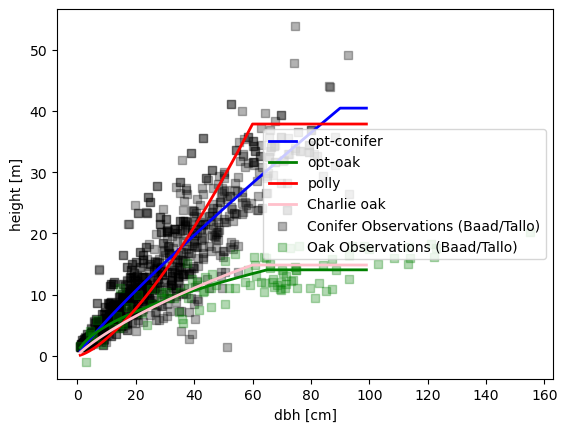

In [32]:
#optimal min
h_opt = d2h_obrien(ds = diams,
                            p1 = get_allom_param_value('PIPO-CADE-ABCO','obrien','fates_allom_d2h1')[2],
                            p2 = get_allom_param_value('PIPO-CADE-ABCO','obrien','fates_allom_d2h2')[2],
                            dbh_maxh = dbh_maxheight_conifer)

plt.plot(diams, h_opt, label = "opt-conifer",color = "blue", lw = 2)

h_opt_oak = d2h_obrien(ds = diams,
                            p1 = get_allom_param_value('QUAG','obrien','fates_allom_d2h1')[2],
                            p2 = get_allom_param_value('QUAG','obrien','fates_allom_d2h2')[2],
                            dbh_maxh = dbh_maxheight_oak)

plt.plot(diams, h_opt_oak, label = "opt-oak",color = "green", lw = 2)

#Polly's
h_polly = d2h_obrien(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2h1"],
                            p2 = pollys_params[0]["fates_allom_d2h2"],
                            dbh_maxh = 60)
plt.plot(diams, h_polly, label = "polly",color = "red", lw = 2)

#Baad data
plt.scatter(conifer_allom_df_height.dbh_cm, conifer_allom_df_height['height_m'],
            label = "Conifer Observations (Baad/Tallo)",color = "black", marker = "s", alpha = 0.3)


plt.scatter(oak_allom_df_height.dbh_cm, oak_allom_df_height['height_m'],
            label = "Oak Observations (Baad/Tallo)",color = "green", marker = "s", alpha = 0.3)


#charlie's

h_oak_charlie = d2h_poorter2006(diams,
                                p1=46.5041,
                                p2=-0.01157,
                                p3=0.855482,dbh_maxh=60)

plt.plot(diams, h_oak_charlie,
            label = "Charlie oak",color = "pink",lw = 2)

plt.xlabel('dbh [cm]')
plt.ylabel('height [m]')
#plt.xlim(0,30)
#plt.ylim(0,10)
plt.legend()
plt.show()

## Diameter to leaf biomass

### For ABCO (grand fir leaf biomass allometry is proxy for ABCO)

In [33]:
baad_ABCO_leafbio = prep_data_for_curve_fit(baad_df,["Abies grandis"],"dbh_cm","leaf_biomass_kgC")

#### d2blmax_salda: Find optimal parameters for the  function used in Buotte et al., 2021

In [34]:
popt, pcov = curve_fit(lambda d, p1, p2, p3: d2blmax_salda(d, p1, p2, p3, wood_density= 0.446, dbh_maxh=dbh_maxheight_conifer),
                       xdata=list(baad_ABCO_leafbio['dbh_cm']), ydata=list(baad_ABCO_leafbio["leaf_biomass_kgC"]))


# Issue grabbing the se of the parameters here
fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

fates_allom_d2bl3 = getMeanMinMaxofParam(param = 2)
print("fates_allom_d2bl3",fates_allom_d2bl3)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1,"ABCO","d2blmax_salda")
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2,"ABCO","d2blmax_salda")
add_param_to_allometry_dict("fates_allom_d2bl3",fates_allom_d2bl3,"ABCO","d2blmax_salda")

fates_allom_d2bl1 [-2.07895263e+06  2.07895370e+06  5.33879227e-01]
fates_allom_d2bl2 [1.26632646 1.60788532 1.43710589]
fates_allom_d2bl3 [-4.81374996e+06  4.81375332e+06  1.68012378e+00]


#### d2blmax_salda: Visualize leaf biomass allometry

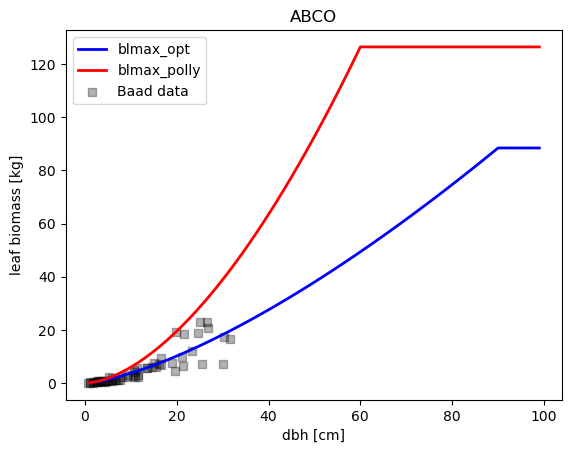

In [35]:
#Opt
blmax_opt_fir = d2blmax_salda(ds = diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            p3 = fates_allom_d2bl3[2],
                            wood_density = 0.446,
                            dbh_maxh = dbh_maxheight_conifer)
plt.plot(diams, blmax_opt_fir, label = "blmax_opt",color = "blue", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[2]["fates_allom_d2bl1"],
                            p2 = pollys_params[2]["fates_allom_d2bl2"],
                            p3 = pollys_params[2]["fates_allom_d2bl3"],
                            wood_density = 0.482,
                            dbh_maxh = 60)
plt.plot(diams, blmax_polly, label = "blmax_polly",color = "red", lw = 2)


#Baad data
plt.scatter(baad_ABCO_leafbio.dbh_cm, baad_ABCO_leafbio["leaf_biomass_kgC"], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.title("ABCO")
plt.show()

#### d2blmax_2pwr: Find optimal parameters

We are going to use this functional form instead because it doesn't have a dependency with wood density.

We want to implement the max_dbh option so we will set `fates_allom_lmode = 3` (see [here](https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L455C23-L455C34) in FATES code)

In [36]:
popt, pcov = curve_fit(lambda d, p1, p2: d2blmax_2pwr(d, p1, p2, c2b, dbh_maxh=dbh_maxheight_conifer),
                       xdata=list(baad_ABCO_leafbio['dbh_cm']), ydata=list(baad_ABCO_leafbio["leaf_biomass_kgC"]))

fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1,"ABCO","d2blmax_2pwr")
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2,"ABCO","d2blmax_2pwr")

fates_allom_d2bl1 [0.12826121 0.42166672 0.27496396]
fates_allom_d2bl2 [1.26804807 1.60621819 1.43713313]


#### d2blmax_2pwr: visualize

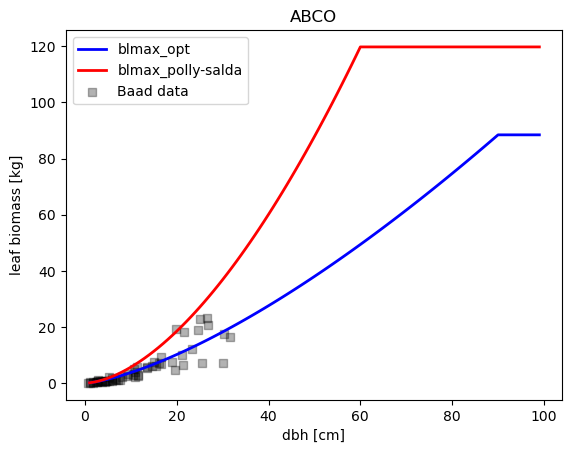

In [37]:
#Opt
blmax_opt_fir = d2blmax_2pwr(diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            c2b=c2b,
                            dbh_maxh = dbh_maxheight_conifer)
plt.plot(diams, blmax_opt_fir, label = "blmax_opt",color = "blue", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[2]["fates_allom_d2bl1"],
                            p2 = pollys_params[2]["fates_allom_d2bl2"],
                            p3 = pollys_params[2]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 60)
plt.plot(diams, blmax_polly, label = "blmax_polly-salda",color = "red", lw = 2)



#Baad data
plt.scatter(baad_ABCO_leafbio.dbh_cm, baad_ABCO_leafbio["leaf_biomass_kgC"], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.title("ABCO")
plt.show()

### For PIPO/CADE

Following Buotte et al. 2021 we assume PIPO and CADE have the same leaf allometry

In [38]:
baad_pipo_leafbio = prep_data_for_curve_fit(baad_df,["Pinus ponderosa"],"dbh_cm","leaf_biomass_kgC")

#### d2blmax_salda find optimal params

In [39]:
popt, pcov = curve_fit(lambda d, p1, p2, p3: d2blmax_salda(d, p1, p2, p3, wood_density= 0.446, dbh_maxh=dbh_maxheight_conifer),
                       xdata=list(baad_pipo_leafbio['dbh_cm']), ydata=list(baad_pipo_leafbio["leaf_biomass_kgC"]))

# Issue grabbing the se of the parameters here
fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

fates_allom_d2bl3 = getMeanMinMaxofParam(param = 2)
print("fates_allom_d2bl3",fates_allom_d2bl3)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1,'PIPO',"d2blmax_salda")
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2,'PIPO',"d2blmax_salda")
add_param_to_allometry_dict("fates_allom_d2bl3",fates_allom_d2bl3,'PIPO',"d2blmax_salda")

fates_allom_d2bl1 [       nan        nan 0.12380564]
fates_allom_d2bl2 [1.89981957 2.12260245 2.01121101]
fates_allom_d2bl3 [      nan       nan 3.0955143]


/tmp/ipykernel_8834/1648507850.py:156: RuntimeWarning: invalid value encountered in sqrt
  sd_of_param = np.sqrt(np.diag(pcov))[param]


#### Visualize leaf biomass allometry

Green line shows that fir has more leaf biomass than pine.

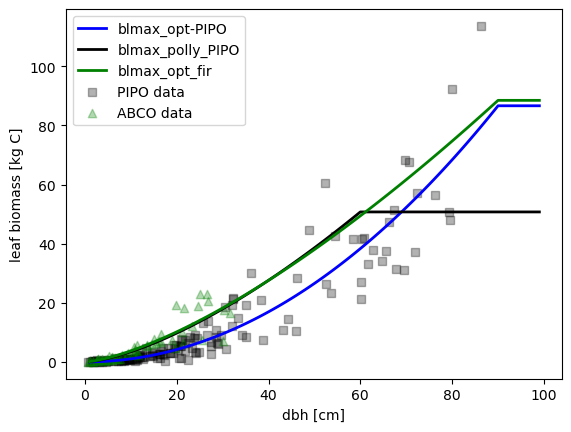

In [40]:
#Opt
blmax_opt = d2blmax_salda(ds = diams,
                            p1 = get_allom_param_value('PIPO','d2blmax_salda','fates_allom_d2bl1')[2],
                            p2 = get_allom_param_value('PIPO','d2blmax_salda','fates_allom_d2bl2')[2],
                            p3 = get_allom_param_value('PIPO','d2blmax_salda','fates_allom_d2bl3')[2],
                            wood_density = 0.446,
                            dbh_maxh = dbh_maxheight_conifer)
plt.plot(diams, blmax_opt, label = "blmax_opt-PIPO",color = "blue", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2bl1"],
                            p2 = pollys_params[0]["fates_allom_d2bl2"],
                            p3 = pollys_params[0]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 60)
plt.plot(diams, blmax_polly, label = "blmax_polly_PIPO",color = "black", lw = 2)

plt.plot(diams, blmax_opt_fir, label = "blmax_opt_fir",color = "green", lw = 2)

#Baad data
plt.scatter(baad_pipo_leafbio.dbh_cm, baad_pipo_leafbio["leaf_biomass_kgC"], label = "PIPO data",color = "black", marker = "s", alpha = 0.3)
plt.scatter(baad_ABCO_leafbio.dbh_cm, baad_ABCO_leafbio["leaf_biomass_kgC"], label = "ABCO data",color = "green", marker = "^", alpha = 0.3)



plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg C]')
plt.legend()
plt.show()

#### d2blmax_2pwr: optimize

In [41]:
popt, pcov = curve_fit(lambda d, p1, p2: d2blmax_2pwr(d, p1, p2, c2b, dbh_maxh=dbh_maxheight_conifer),
                       xdata=list(baad_pipo_leafbio['dbh_cm']), ydata=list(baad_pipo_leafbio["leaf_biomass_kgC"]))

fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1,"PIPO","d2blmax_2pwr")
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2,"PIPO","d2blmax_2pwr")

fates_allom_d2bl1 [0.01080429 0.02986945 0.02033687]
fates_allom_d2bl2 [1.89974477 2.12267634 2.01121056]


#### d2blmax_2pwr: visualize

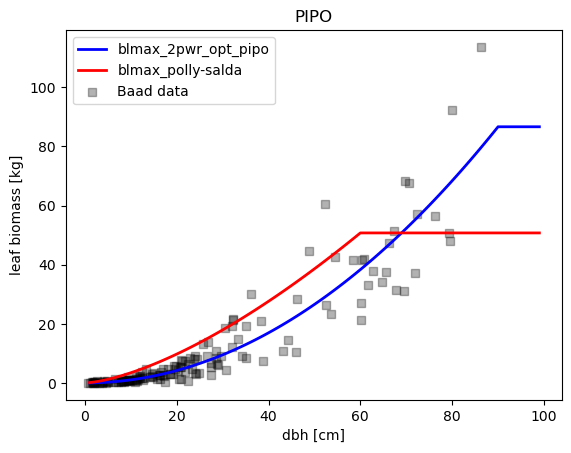

In [42]:
#Opt
blmax_opt_pipo = d2blmax_2pwr(diams,
                            p1 = get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl1')[2],
                            p2 = get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl2')[2],
                            c2b=c2b,
                            dbh_maxh = dbh_maxheight_conifer)
plt.plot(diams, blmax_opt_pipo, label = "blmax_2pwr_opt_pipo",color = "blue", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2bl1"],
                            p2 = pollys_params[0]["fates_allom_d2bl2"],
                            p3 = pollys_params[0]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 60)
plt.plot(diams, blmax_polly, label = "blmax_polly-salda",color = "red", lw = 2)



#Baad data
plt.scatter(baad_pipo_leafbio.dbh_cm, baad_pipo_leafbio["leaf_biomass_kgC"], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.title("PIPO")
plt.show()

### For oak

In [43]:
baad_QUAG_leafbio = prep_data_for_curve_fit(tree_allom_df,["Quercus agrifolia"],"dbh_cm","leaf_biomass_kgC")
baad_QUAG_leafbio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 1343 to 3031
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dbh_cm            70 non-null     float64
 1   leaf_biomass_kgC  70 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [44]:
popt, pcov = curve_fit(lambda d, p1, p2: d2blmax_2pwr(d, p1, p2, c2b, dbh_maxh=dbh_maxheight_oak),
                       xdata=list(baad_QUAG_leafbio['dbh_cm']), ydata=list(baad_QUAG_leafbio["leaf_biomass_kgC"]))

fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1,"QUAG","d2blmax_2pwr")
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2,"QUAG","d2blmax_2pwr")

fates_allom_d2bl1 [-0.0473865   0.16254802  0.05758076]
fates_allom_d2bl2 [1.45057742 2.3346072  1.89259231]


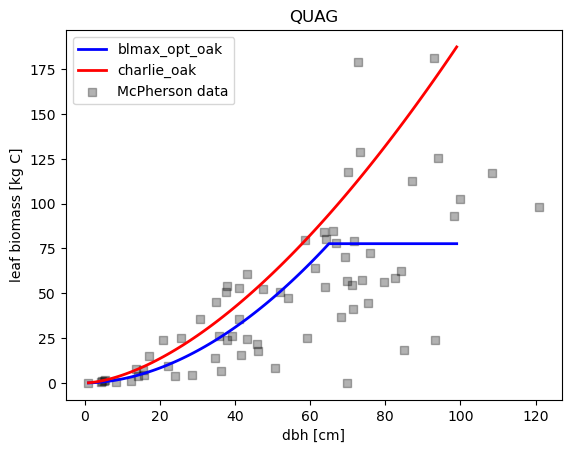

In [45]:
#Baad data

#Opt
blmax_opt_oak = d2blmax_2pwr(diams,
                            p1 = get_allom_param_value('QUAG','d2blmax_2pwr','fates_allom_d2bl1')[2],
                            p2 = get_allom_param_value('QUAG','d2blmax_2pwr','fates_allom_d2bl2')[2],
                            c2b=c2b,
                            dbh_maxh = dbh_maxheight_oak)
plt.plot(diams, blmax_opt_oak, label = "blmax_opt_oak",color = "blue", lw = 2)


# Charlie uses the 2param power function, but with an uncapped dbh (lmode = 2)
blmax_opt_oak = d2blmax_2pwr(diams,
                            p1 = 0.2,
                            p2 = 1.64,
                            c2b=c2b,
                            dbh_maxh = 1000)
plt.plot(diams, blmax_opt_oak, label = "charlie_oak",color = "red", lw = 2)



plt.scatter(baad_QUAG_leafbio.dbh_cm, baad_QUAG_leafbio["leaf_biomass_kgC"], label = "McPherson data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg C]')
plt.legend()
plt.title("QUAG")
plt.show()

## Diameter to crown area


We are going to exclude the McPherson data for crown area here because it seems to have a low bias in crown area, perhaps related to trimming in urban areas.

In [46]:
print(tree_allom_df.loc[pd.notnull(tree_allom_df['crown_area_m2'])]['species'].value_counts())


#tree_allom_df.loc[(pd.notnull(tree_allom_df['crown_area_m2'])) & (tree_allom_df['species'] == "Calocedrus decurrens")]

McPherson_QUAG_crown_area_data = tree_allom_df.loc[tree_allom_df['species'] == "Quercus agrifolia"]
crown_area_df = tree_allom_df.loc[tree_allom_df['source'] != "McPherson_2016"]
crown_area_df = pd.concat([crown_area_df,McPherson_QUAG_crown_area_data])


crown_area_df.info()

Pinus ponderosa          640
Abies grandis            199
Quercus agrifolia        103
Abies concolor            43
Calocedrus decurrens      39
Pseudotsuga menziesii     39
Quercus wislizeni          8
Quercus douglasii          6
Name: species, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 80263 to 3057
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1500 non-null   object 
 1   dbh_cm            1478 non-null   float64
 2   height_m          1496 non-null   float64
 3   leaf_biomass_kgC  292 non-null    object 
 4   agwb_kgC          278 non-null    object 
 5   agb_kgC           1185 non-null   object 
 6   crown_area_m2     939 non-null    float64
 7   source            1500 non-null   object 
dtypes: float64(3), object(5)
memory usage: 105.5+ KB


### For PIPO/CADE

The conifers have similar dbh to crown area, but we will need to have fir have a different `ediff` value because it has a different leaf biomass allometry. 

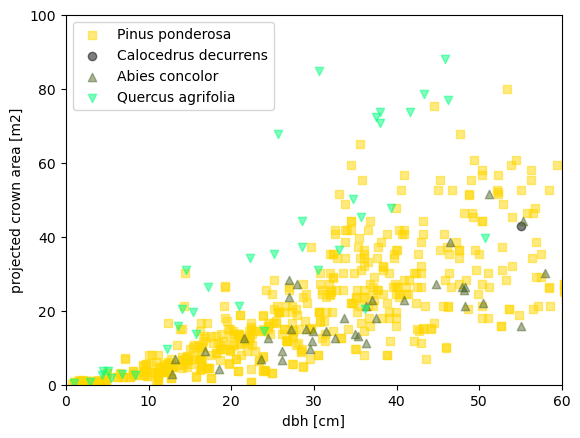

In [47]:
sp_names_crown_area = ['Pinus ponderosa','Calocedrus decurrens','Abies concolor','Quercus agrifolia']

crown_area_data = []

for i,p in enumerate(sp_names_crown_area):
    crown_area_data.append(prep_data_for_curve_fit(crown_area_df,[p],"dbh_cm","crown_area_m2"))
    plt.scatter(crown_area_data[i]['dbh_cm'],crown_area_data[i]['crown_area_m2'],label=p,
                color = pft_colors[i],
                marker=pft_symbols[i],
                alpha=0.5)
    plt.legend()

plt.xlabel('dbh [cm]')
plt.ylabel('projected crown area [m2]')
plt.xlim(0,60)
plt.ylim(0,100)
plt.show()

#### Find optimal params

In [48]:
allow_spread = False

pipo_ca = prep_data_for_curve_fit(crown_area_df,["Pinus ponderosa"],"dbh_cm","crown_area_m2")

popt, pcov = curve_fit(lambda d, p1, p2: carea_2pwr(d, p1, p2),
                       xdata=list(pipo_ca['dbh_cm']), ydata=list(pipo_ca["crown_area_m2"]))

# p1 is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

d2ca_base = getMeanMinMaxofParam(param = 0)
d2ca_expo = getMeanMinMaxofParam(param = 1)

print("d2ca_base (derived from curve fit):", d2ca_base)
print("d2ca_expo (derived from curve fit):",d2ca_expo)

if allow_spread == True:
    # Use variation in the estimate of the base parameter for fates_allom_d2ca_coefficient_(min/max)
    fates_allom_d2ca_coefficient_min = [d2ca_base[0] * 0.85, d2ca_base[0] * 1.15, d2ca_base[0]]
    fates_allom_d2ca_coefficient_max = [d2ca_base[1] * 0.85, d2ca_base[1] * 1.15, d2ca_base[1]]

else:
    fates_allom_d2ca_coefficient_min = fates_allom_d2ca_coefficient_max = d2ca_base

print("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
print("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)


# The exponent in FATES is calculated by adding and "exponent diff param" to fates_allom_d2bl2


fates_allom_d2bl2_pipo_2pwr = get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl2')
print("fates_allom_d2bl2_pipo",fates_allom_d2bl2_pipo_2pwr)
fates_allom_blca_expnt_diff_pipo = d2ca_expo - fates_allom_d2bl2_pipo_2pwr
print("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff_pipo)


add_param_to_allometry_dict("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min,"PIPO","carea_2pwr")
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max,"PIPO","carea_2pwr")
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff_pipo,"PIPO","carea_2pwr")

fates_allom_d2bl2_abco_2pwr = get_allom_param_value('ABCO','d2blmax_2pwr','fates_allom_d2bl2')
print("fates_allom_d2bl2_abco",fates_allom_d2bl2_abco_2pwr)
fates_allom_blca_expnt_diff_abco = d2ca_expo - fates_allom_d2bl2_abco_2pwr
print("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff_abco)
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff_abco,"ABCO","carea_2pwr")

d2ca_base (derived from curve fit): [0.25695434 0.37009646 0.3135254 ]
d2ca_expo (derived from curve fit): [1.1723043  1.26372459 1.21801445]
fates_allom_d2ca_coefficient_min [0.25695434 0.37009646 0.3135254 ]
fates_allom_d2ca_coefficient_max [0.25695434 0.37009646 0.3135254 ]
fates_allom_d2bl2_pipo [1.89974477 2.12267634 2.01121056]
fates_allom_blca_expnt_diff [-0.72744047 -0.85895175 -0.79319611]
fates_allom_d2bl2_abco [1.26804807 1.60621819 1.43713313]
fates_allom_blca_expnt_diff [-0.09574376 -0.3424936  -0.21911868]


### For oak

In [49]:
allow_spread = False

quag_ca = prep_data_for_curve_fit(crown_area_df,["Quercus agrifolia"],"dbh_cm","crown_area_m2")

popt, pcov = curve_fit(lambda d, p1, p2: carea_2pwr(d, p1, p2),
                       xdata=list(quag_ca['dbh_cm']), ydata=list(quag_ca["crown_area_m2"]))

# p1 is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

d2ca_base = getMeanMinMaxofParam(param = 0)
d2ca_expo = getMeanMinMaxofParam(param = 1)

print("d2ca_base (derived from curve fit):", d2ca_base)
print("d2ca_expo (derived from curve fit):",d2ca_expo)

if allow_spread == True:
    # Use variation in the estimate of the base parameter for fates_allom_d2ca_coefficient_(min/max)
    fates_allom_d2ca_coefficient_min = [d2ca_base[0] * 0.85, d2ca_base[0] * 1.15, d2ca_base[0]]
    fates_allom_d2ca_coefficient_max = [d2ca_base[1] * 0.85, d2ca_base[1] * 1.15, d2ca_base[1]]

else:
    fates_allom_d2ca_coefficient_min = fates_allom_d2ca_coefficient_max = d2ca_base

print("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
print("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)


# The exponent in FATES is calculated by adding and "exponent diff param" to fates_allom_d2bl2

fates_allom_d2bl2_quag_2pwr = get_allom_param_value('QUAG','d2blmax_2pwr','fates_allom_d2bl2')
print("fates_allom_d2bl2_quag",fates_allom_d2bl2_quag_2pwr)
fates_allom_blca_expnt_diff_quag = d2ca_expo - fates_allom_d2bl2_quag_2pwr
print("fates_allom_blca_expnt_diff_quag",fates_allom_blca_expnt_diff_quag)


add_param_to_allometry_dict("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min,"QUAG","carea_2pwr")
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max,"QUAG","carea_2pwr")
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff_quag,"QUAG","carea_2pwr")

d2ca_base (derived from curve fit): [0.6332177  1.64406949 1.13864359]
d2ca_expo (derived from curve fit): [1.10915378 1.3080276  1.20859069]
fates_allom_d2ca_coefficient_min [0.6332177  1.64406949 1.13864359]
fates_allom_d2ca_coefficient_max [0.6332177  1.64406949 1.13864359]
fates_allom_d2bl2_quag [1.45057742 2.3346072  1.89259231]
fates_allom_blca_expnt_diff_quag [-0.34142364 -1.0265796  -0.68400162]


### Visualize diameter to crown area

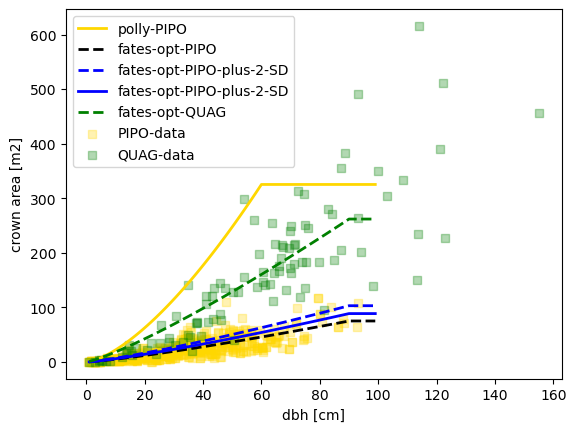

In [50]:
#Polly's params
ca,cd = d_to_crown_area_fates(ds=diams,
                                         d2bl_p2=pollys_params[0]['fates_allom_d2bl2'],
                                         d2bl_ediff=pollys_params[0]["fates_allom_blca_expnt_diff"],
                                         d2ca_max=pollys_params[0]["fates_allom_d2ca_coefficient_max"],
                                         d2ca_min=pollys_params[0]["fates_allom_d2ca_coefficient_min"],
                                         spread=0.5,dbh_maxh=60)
plt.plot(diams, ca, label = "polly-PIPO",color = pft_colors[0], lw = 2)

# Optimized fates params PIPO
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl2')[2],
                              d2bl_ediff=get_allom_param_value('PIPO','carea_2pwr','fates_allom_blca_expnt_diff')[2],
                              d2ca_max=get_allom_param_value('PIPO','carea_2pwr','fates_allom_d2ca_coefficient_max')[2],
                              d2ca_min=get_allom_param_value('PIPO','carea_2pwr','fates_allom_d2ca_coefficient_min')[2],
                              spread=0.5, dbh_maxh=dbh_maxheight_conifer)
plt.plot(diams, ca, label = "fates-opt-PIPO",color = "black", lw = 2, linestyle = "--")


# Optimized fates params PIPO + and 1 extra standard deviation
# This value for d2ca was used as the max end of the range in ensemble2 (100223)
# Because analysis of the ensemble 1 showed that raising this could increase
# coexistence between oaks and conifers
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl2')[2],
                              d2bl_ediff=get_allom_param_value('PIPO','carea_2pwr','fates_allom_blca_expnt_diff')[2],
                              d2ca_max=0.43,
                              d2ca_min=0.43,
                              spread=0.5, dbh_maxh=dbh_maxheight_conifer)
plt.plot(diams, ca, label = "fates-opt-PIPO-plus-2-SD",color = "blue", lw = 2, linestyle = "--")


ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=get_allom_param_value('PIPO','d2blmax_2pwr','fates_allom_d2bl2')[2],
                              d2bl_ediff=get_allom_param_value('PIPO','carea_2pwr','fates_allom_blca_expnt_diff')[2],
                              d2ca_max=0.37,
                              d2ca_min=0.37,
                              spread=0.5, dbh_maxh=dbh_maxheight_conifer)
plt.plot(diams, ca, label = "fates-opt-PIPO-plus-2-SD",color = "blue", lw = 2)


# Optimized fates params ABCO
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=get_allom_param_value('ABCO','d2blmax_2pwr','fates_allom_d2bl2')[2],
                              d2bl_ediff=get_allom_param_value('ABCO','carea_2pwr','fates_allom_blca_expnt_diff')[2],
                              d2ca_max=get_allom_param_value('PIPO','carea_2pwr','fates_allom_d2ca_coefficient_max')[2],
                              d2ca_min=get_allom_param_value('PIPO','carea_2pwr','fates_allom_d2ca_coefficient_min')[2],
                              spread=0.5, dbh_maxh=dbh_maxheight_conifer)
#plt.plot(diams, ca, label = "fates-opt-ABCO",color = "green", lw = 2, linestyle = "--")


# Optimized fates params QUAG
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=get_allom_param_value('QUAG','d2blmax_2pwr','fates_allom_d2bl2')[2],
                              d2bl_ediff=get_allom_param_value('QUAG','carea_2pwr','fates_allom_blca_expnt_diff')[2],
                              d2ca_max=get_allom_param_value('QUAG','carea_2pwr','fates_allom_d2ca_coefficient_max')[2],
                              d2ca_min=get_allom_param_value('QUAG','carea_2pwr','fates_allom_d2ca_coefficient_min')[2],
                              spread=0.5, dbh_maxh=dbh_maxheight_conifer)
plt.plot(diams, ca, label = "fates-opt-QUAG",color = "green", lw = 2, linestyle = "--")


#Baad data
plt.scatter(pipo_ca['dbh_cm'], pipo_ca['crown_area_m2'], label = "PIPO-data",
            color = pft_colors[0], marker = "s", alpha=0.3)

#Baad data
plt.scatter(quag_ca['dbh_cm'], quag_ca['crown_area_m2'], label = "QUAG-data",
            color = "green", marker = "s", alpha=0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('crown area [m2]')
plt.legend()
#plt.xlim(0,60)
#plt.ylim(0,100)
plt.show()

## Diameter to AGWB

These values are derived by taking the Chojnacky 2014 equations, predicting total agb on trees for which we have leaf biomass observations and then subtracting leaf biomass for those trees.

In [51]:
agwb_df = tree_allom_df.loc[pd.notna(tree_allom_df['agwb_kgC'])]

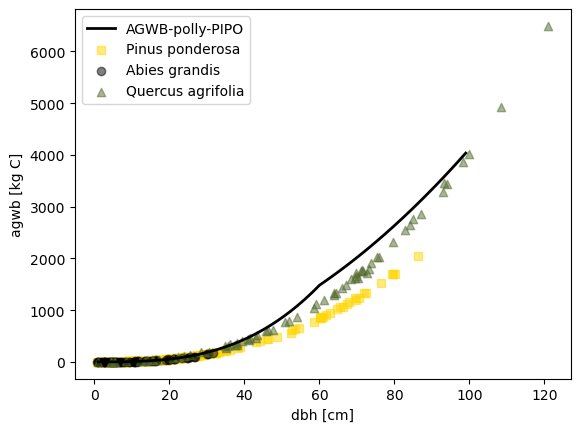

In [52]:
sp_names_agwb = ['Pinus ponderosa',
                 'Abies grandis',
                 'Quercus agrifolia']

agwb_data = []

for i,p in enumerate(sp_names_agwb):
    agwb_data.append(prep_data_for_curve_fit(agwb_df,[p],"dbh_cm","agwb_kgC"))
    plt.scatter(agwb_data[i]['dbh_cm'],agwb_data[i]['agwb_kgC'],label=p,
                color = pft_colors[i],alpha=0.5,marker=pft_symbols[i])
    plt.legend()

    
agwb_polly = dh2bagw_salda(p1 = pollys_params[0]["fates_allom_agb1"],
              p2 = pollys_params[0]["fates_allom_agb2"],
              p3 = pollys_params[0]["fates_allom_agb3"],
              p4 = pollys_params[0]["fates_allom_agb4"],
              allom_agb_frac=0.6,
              ds=diams,
              heights=h_polly,
              wood_density=0.446)    

plt.plot(diams, agwb_polly, label = "AGWB-polly-PIPO",color = "black", lw = 2)

plt.xlabel('dbh [cm]')
plt.ylabel('agwb [kg C]')
plt.legend()
#plt.xlim(0,40)
#plt.ylim(0,200)
plt.show()

### Get optimal params


We are using the `d2bagw_2pwr` function. `fates_allom_amode = 2`

In [53]:
data_for_agwb_curve_fit = []
popts = []
pcovs = []
for i,p in enumerate(sp_names_agwb):
    
    data_for_agwb_curve_fit = prep_data_for_curve_fit(agwb_df,[p],"dbh_cm","agwb_kgC")

    popt, pcov = curve_fit(lambda d, p1, p2: d2bagw_2pwr(d, p1, p2, c2b),
                       xdata=list(data_for_agwb_curve_fit['dbh_cm']), ydata=list(data_for_agwb_curve_fit['agwb_kgC']))
    
    fates_allom_agb1 = getMeanMinMaxofParam(param = 0)
    fates_allom_agb2 = getMeanMinMaxofParam(param = 1)
    
    add_param_to_allometry_dict("fates_allom_agb1",fates_allom_agb1,p,"d2bagw_2pwr")
    add_param_to_allometry_dict("fates_allom_agb2",fates_allom_agb2,p,"d2bagw_2pwr")


### Visualize total AGB in young trees

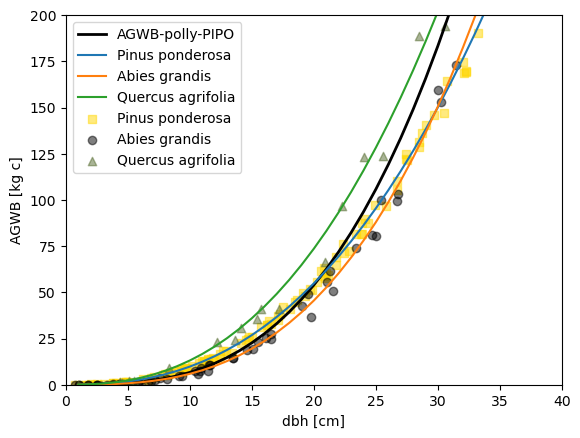

In [54]:
agwb_polly = dh2bagw_salda(p1 = pollys_params[0]["fates_allom_agb1"],
              p2 = pollys_params[0]["fates_allom_agb2"],
              p3 = pollys_params[0]["fates_allom_agb3"],
              p4 = pollys_params[0]["fates_allom_agb4"],
              allom_agb_frac=0.6,
              ds=diams,
              heights=h_polly,
              wood_density=0.446)

agb_polly = np.array(agwb_polly) #+ np.array(blmax_polly)
plt.plot(diams, agb_polly, label = "AGWB-polly-PIPO",color = "black", lw = 2)

for i,p in enumerate(sp_names_agwb):
    to_plot = d2bagw_2pwr(diams, 
                   p1=get_allom_param_value(p,'d2bagw_2pwr','fates_allom_agb1')[2],
                   p2=get_allom_param_value(p,'d2bagw_2pwr','fates_allom_agb2')[2], c2b=c2b)
    
    plt.plot(diams,to_plot,label = p)

    
# Add the data
agwb_data = []

for i,p in enumerate(sp_names_agwb):
    agwb_data.append(prep_data_for_curve_fit(agwb_df,[p],"dbh_cm","agwb_kgC"))
    plt.scatter(agwb_data[i]['dbh_cm'],agwb_data[i]['agwb_kgC'],label=p,
                color = pft_colors[i],alpha=0.5,marker=pft_symbols[i])
    plt.legend()

plt.xlabel('dbh [cm]')
plt.ylabel('AGWB [kg c]')
plt.xlim(0,40)
plt.ylim(0,200)
plt.legend()
plt.show()

### Visualize total AGB across full range of dbh

In [55]:
sp_names_agwb

['Pinus ponderosa', 'Abies grandis', 'Quercus agrifolia']

In [56]:
get_allom_param_value('Pinus ponderosa','d2bagw_2pwr','fates_allom_agb1')

array([0.06303578, 0.06642567, 0.06473072])

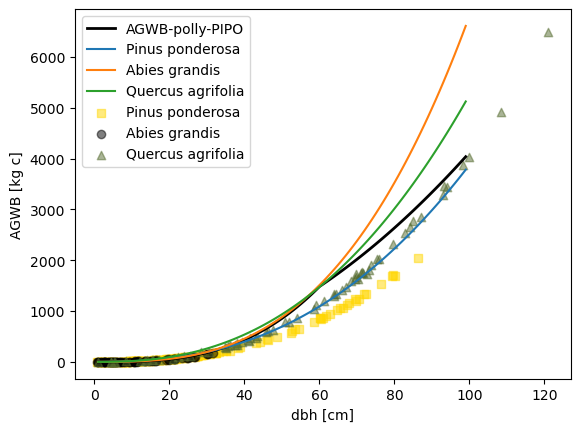

In [57]:
agwb_polly = dh2bagw_salda(p1 = pollys_params[0]["fates_allom_agb1"],
              p2 = pollys_params[0]["fates_allom_agb2"],
              p3 = pollys_params[0]["fates_allom_agb3"],
              p4 = pollys_params[0]["fates_allom_agb4"],
              allom_agb_frac=0.6,
              ds=diams,
              heights=h_polly,
              wood_density=0.446)

agb_polly = np.array(agwb_polly) #+ np.array(blmax_polly)
plt.plot(diams, agb_polly, label = "AGWB-polly-PIPO",color = "black", lw = 2)

for i,p in enumerate(sp_names_agwb):
    to_plot = d2bagw_2pwr(diams, 
                   p1=get_allom_param_value(p,'d2bagw_2pwr','fates_allom_agb1')[2] * 1.3,
                   p2=get_allom_param_value(p,'d2bagw_2pwr','fates_allom_agb2')[2], c2b=c2b)
    
    plt.plot(diams,to_plot,label = p)

sp_names_agwb = ['Pinus ponderosa',
                 'Abies grandis',
                 'Quercus agrifolia']

agwb_data = []

for i,p in enumerate(sp_names_agwb):
    agwb_data.append(prep_data_for_curve_fit(agwb_df,[p],"dbh_cm","agwb_kgC"))
    plt.scatter(agwb_data[i]['dbh_cm'],agwb_data[i]['agwb_kgC'],label=p,
                color = pft_colors[i],alpha=0.5,marker=pft_symbols[i])
    plt.legend()

plt.xlabel('dbh [cm]')
plt.ylabel('AGWB [kg c]')

plt.legend()
plt.show()

In [58]:
pd.DataFrame(allometry_dict)

,fates_name,min_value,max_value,mean,sp,allom_mod
0,fates_allom_dbh_maxheight,9.000000e+01,9.000000e+01,90.000000,PIPO,NaN
1,fates_allom_dbh_maxheight,6.500000e+01,6.500000e+01,65.000000,QUAG,NaN
2,fates_allom_d2h1,8.728770e-01,9.048035e-01,0.888840,PIPO-CADE-ABCO,obrien
3,fates_allom_d2h2,-1.563454e-01,-1.034456e-01,-0.129896,PIPO-CADE-ABCO,obrien
4,fates_allom_d2h1,5.074388e-01,6.223882e-01,0.564913,QUAG,obrien
5,fates_allom_d2h2,2.305451e-02,2.237809e-01,0.123418,QUAG,obrien
6,fates_allom_d2bl1,-2.078953e+06,2.078954e+06,0.533879,ABCO,d2blmax_salda
7,fates_allom_d2bl2,1.266326e+00,1.607885e+00,1.437106,ABCO,d2blmax_salda
8,fates_allom_d2bl3,-4.813750e+06,4.813753e+06,1.680124,ABCO,d2blmax_salda
9,fates_allom_d2bl1,1.282612e-01,4.216667e-01,0.274964,ABCO,d2blmax_2pwr


The Abies grandis curve overtakes ponderosa in larger size classes, but this part of its range is greatly extrapolated beyond observations, so I'm going to use PIPO's agwb allometry for fir.

## Check range of possible tree vai's

In [59]:
allometry_range_df = pd.DataFrame.from_dict(allometry_dict)
allometry_range_df

,fates_name,min_value,max_value,mean,sp,allom_mod
0,fates_allom_dbh_maxheight,9.000000e+01,9.000000e+01,90.000000,PIPO,NaN
1,fates_allom_dbh_maxheight,6.500000e+01,6.500000e+01,65.000000,QUAG,NaN
2,fates_allom_d2h1,8.728770e-01,9.048035e-01,0.888840,PIPO-CADE-ABCO,obrien
3,fates_allom_d2h2,-1.563454e-01,-1.034456e-01,-0.129896,PIPO-CADE-ABCO,obrien
4,fates_allom_d2h1,5.074388e-01,6.223882e-01,0.564913,QUAG,obrien
5,fates_allom_d2h2,2.305451e-02,2.237809e-01,0.123418,QUAG,obrien
6,fates_allom_d2bl1,-2.078953e+06,2.078954e+06,0.533879,ABCO,d2blmax_salda
7,fates_allom_d2bl2,1.266326e+00,1.607885e+00,1.437106,ABCO,d2blmax_salda
8,fates_allom_d2bl3,-4.813750e+06,4.813753e+06,1.680124,ABCO,d2blmax_salda
9,fates_allom_d2bl1,1.282612e-01,4.216667e-01,0.274964,ABCO,d2blmax_2pwr


Max of range for sla:

(taken from my param ranges file)

* PIPO: 0.011
* ABCO/CADE: 0.0122221 (PIPO * 1.111)
* Shrub: 0.0538
* Oak: 0.0156

In [60]:
def vai_check(diams,d2bl1,d2bl2,d2ca,ediff,sai_per_lai,dbh_maxh,slamax,c2b,vai_max=30,print_leaf_area = False):
    '''
    Returns the total vai of a tree and a warning of the vai is greater than the allowed maximum.
    
    
    Params
    diams = range of dbh to check vai for,
    d2bl1 = dbh to leaf biomass p1
    d2bl2 = dbh to leaf biomass p2
    d2ca = diameter to crown area parameter (base of the d2ca 2pwr function)
    ediff = exponent different for the d2ca function
    sai_per_lai = how much stem area index per lai
    dbh_maxh = dbh at maximum height
    slamax = maximum specific leaf area (m2 per g of carbon)
    c2b = grams of biomass per g of carbon
    vai_max = the allowed maximum vai for a tree
    '''
    
    print("Using the following parameters:\n")
    print("d2bl1",d2bl1)
    print("d2bl2",d2bl2)
    print("d2ca",d2ca)
    print("ediff",ediff)
    print("sai_per_lai",sai_per_lai)
    print("dbh_maxh",dbh_maxh)
    print("slamax",slamax)
    print("c2b",c2b)
    
    
    # Calculate total tree leaf area (m2)
    leaf_biomass = d2blmax_2pwr(d = diams,
                            p1 = d2bl1,
                            p2 = d2bl2,
                            c2b=c2b,
                            dbh_maxh = dbh_maxh)
    leaf_biomass_g = np.array(leaf_biomass) * 1000
    leaf_area_m2 = leaf_biomass_g * slamax
    
    if print_leaf_area == True:
        print("leaf_area_m2",leaf_area_m2)
    
    
    # Calculate tree projected crown area (ca) and diameter (cd)
    ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=d2bl2,
                              d2bl_ediff=ediff,
                              d2ca_max=d2ca,
                              d2ca_min=d2ca,
                              spread=0.5,
                              dbh_maxh=dbh_maxh)
    
    tree_vai = (np.array(leaf_area_m2) / np.array(ca)) * (1 + sai_per_lai)
    max_tree_vai = np.max(tree_vai)
    
    print("\nVAI check:")
    
    if max_tree_vai > vai_max:
        print("Warning: tree vai of",max_tree_vai,"exceeds vai max of",vai_max)
    else:
        print("Max vai",max_tree_vai,"is OK")

### PIPO

In [61]:
# for PIPO
print("For PIPO")
vai_check(diams = diams,
          d2bl1 = get_allom_param_value("PIPO","d2blmax_2pwr","fates_allom_d2bl1")[2],
          d2bl2 = get_allom_param_value("PIPO","d2blmax_2pwr","fates_allom_d2bl2")[2],
          d2ca = get_allom_param_value("PIPO","carea_2pwr","fates_allom_d2ca_coefficient_max")[0],
          #d2ca = 0.45,
          ediff = get_allom_param_value("PIPO","carea_2pwr","fates_allom_blca_expnt_diff")[2],
          sai_per_lai=0.1,
          dbh_maxh=dbh_maxheight_conifer,
          slamax = 0.017,
          c2b = g_biomass_per_g_C,
          vai_max=30,print_leaf_area=True)

For PIPO
Using the following parameters:

d2bl1 0.02033686819895321
d2bl2 2.011210557985228
d2ca 0.256954336176624
ediff -0.7931961108368579
sai_per_lai 0.1
dbh_maxh 90
slamax 0.017
c2b 2
leaf_area_m2 [1.72863380e-01 6.96847434e-01 1.57504985e+00 2.80913371e+00
 4.40026520e+00 6.34934624e+00 8.65711328e+00 1.13241892e+01
 1.43511138e+01 1.77383638e+01 2.14863657e+01 2.55955058e+01
 3.00661369e+01 3.48985840e+01 4.00931480e+01 4.56501093e+01
 5.15697305e+01 5.78522581e+01 6.44979250e+01 7.15069515e+01
 7.88795465e+01 8.66159092e+01 9.47162294e+01 1.03180688e+02
 1.12009460e+02 1.21202712e+02 1.30760603e+02 1.40683288e+02
 1.50970917e+02 1.61623632e+02 1.72641573e+02 1.84024873e+02
 1.95773664e+02 2.07888070e+02 2.20368214e+02 2.33214216e+02
 2.46426191e+02 2.60004251e+02 2.73948506e+02 2.88259062e+02
 3.02936023e+02 3.17979492e+02 3.33389566e+02 3.49166343e+02
 3.65309917e+02 3.81820381e+02 3.98697824e+02 4.15942336e+02
 4.33554004e+02 4.51532911e+02 4.69879141e+02 4.88592777e+02
 5.076

### CADE

In [62]:
# for PIPO
print("For CADE")
vai_check(diams = diams,
          d2bl1 = get_allom_param_value("PIPO","d2blmax_2pwr","fates_allom_d2bl1")[2],
          d2bl2 = get_allom_param_value("PIPO","d2blmax_2pwr","fates_allom_d2bl2")[2],
          d2ca = get_allom_param_value("PIPO","carea_2pwr","fates_allom_d2ca_coefficient_max")[0],
          ediff = get_allom_param_value("PIPO","carea_2pwr","fates_allom_blca_expnt_diff")[2],
          sai_per_lai=0.1,
          dbh_maxh=dbh_maxheight_conifer,
          slamax = 0.017,
          c2b = g_biomass_per_g_C,
          vai_max=30)

For CADE
Using the following parameters:

d2bl1 0.02033686819895321
d2bl2 2.011210557985228
d2ca 0.256954336176624
ediff -0.7931961108368579
sai_per_lai 0.1
dbh_maxh 90
slamax 0.017
c2b 2

VAI check:
Max vai 26.262574179214425 is OK


### ABCO

In [63]:
# for PIPO
print("For ABCO")
vai_check(diams = diams,
          d2bl1 = get_allom_param_value("ABCO","d2blmax_2pwr","fates_allom_d2bl1")[2],
          d2bl2 = get_allom_param_value("ABCO","d2blmax_2pwr","fates_allom_d2bl2")[2],
          d2ca = get_allom_param_value("PIPO","carea_2pwr","fates_allom_d2ca_coefficient_max")[0],
          ediff = get_allom_param_value("ABCO","carea_2pwr","fates_allom_blca_expnt_diff")[2],
          sai_per_lai=0.1,
          dbh_maxh=dbh_maxheight_conifer,
          slamax = 0.017,
          c2b = g_biomass_per_g_C,
          vai_max=30)

For ABCO
Using the following parameters:

d2bl1 0.27496396482460916
d2bl2 1.4371331292127514
d2ca 0.256954336176624
ediff -0.21911868206438134
sai_per_lai 0.1
dbh_maxh 90
slamax 0.017
c2b 2

VAI check:
Max vai 26.818994085625544 is OK


### For oak

In [64]:
get_allom_param_value("QUAG","carea_2pwr","fates_allom_d2ca_coefficient_max")[0]

0.6332176960483354

In [65]:
# get_allom_param_value("QUAG","carea_2pwr","fates_allom_d2ca_coefficient_max")[2]
# for PIPO
print("For QUAG")
vai_check(diams = diams,
          d2bl1 = get_allom_param_value("QUAG","d2blmax_2pwr","fates_allom_d2bl1")[2],
          d2bl2 = get_allom_param_value("QUAG","d2blmax_2pwr","fates_allom_d2bl2")[2],
          d2ca = 0.43,
          ediff = get_allom_param_value("QUAG","carea_2pwr","fates_allom_blca_expnt_diff")[2],
          sai_per_lai=0.1,
          dbh_maxh=dbh_maxheight_oak,
          slamax = 0.0156,
          c2b = g_biomass_per_g_C,
          vai_max=30)

For QUAG
Using the following parameters:

d2bl1 0.05758076287373796
d2bl2 1.8925923120673938
d2ca 0.43
ediff -0.6840016211111637
sai_per_lai 0.1
dbh_maxh 65
slamax 0.0156
c2b 2

VAI check:
Max vai 19.967878323605202 is OK


### For Shrub

In [66]:
# for PIPO
print("For shrub")
vai_check(diams = diams,
          d2bl1 = 0.01919,
          d2bl2 = 1.8565,
          d2ca = 0.26,
          ediff = -0.573300,
          sai_per_lai=0.1,
          dbh_maxh=12.6,
          slamax = 0.0538,
          c2b = g_biomass_per_g_C,
          vai_max=30,
         print_leaf_area=True)

For shrub
Using the following parameters:

d2bl1 0.01919
d2bl2 1.8565
d2ca 0.26
ediff -0.5733
sai_per_lai 0.1
dbh_maxh 12.6
slamax 0.0538
c2b 2
leaf_area_m2 [ 0.516211    1.86934492  3.96828508  6.76942263 10.24389381 14.37027407
 19.13162088 24.51397933 30.50552289 37.09601468 44.27644817 52.03879577
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.

### For ensemble

In [67]:
# for PIPO
print("For PIPO")
vai_check(diams = diams,
          d2bl1 = 0.01919,
          d2bl2 = 1.8565,
          d2ca = 0.26,
          ediff = -0.573300,
          sai_per_lai=0.1,
          dbh_maxh=12.6,
          slamax = 0.0538,
          c2b = g_biomass_per_g_C,
          vai_max=30,
         print_leaf_area=True)

For PIPO
Using the following parameters:

d2bl1 0.01919
d2bl2 1.8565
d2ca 0.26
ediff -0.5733
sai_per_lai 0.1
dbh_maxh 12.6
slamax 0.0538
c2b 2
leaf_area_m2 [ 0.516211    1.86934492  3.96828508  6.76942263 10.24389381 14.37027407
 19.13162088 24.51397933 30.50552289 37.09601468 44.27644817 52.03879577
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618 56.97248618
 56.97248618 56.97248618 56.97248618 56.9

## Write out file

In [68]:
allometry_range_df = pd.DataFrame.from_dict(allometry_dict)

if write_to_csv == True:

    now = datetime.now()
    dt_string = now.strftime("%m-%d-%Y-%H-%M-%S")
    file_path = "conifer_and_oak_allom_param_ranges_data_derived_" + dt_string + ".csv"
    allometry_range_df.to_csv(file_path, index=False)